In [56]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

In [37]:
seed_urls = ['https://inshorts.com/en/read/technology',
             'https://inshorts.com/en/read/sports',
             'https://inshorts.com/en/read/world']

def build_dataset(seed_urls):
    news_data = []
    for url in seed_urls:
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser') #Order in proper HTML format
        
        
        news_articles = [{'news_headline': headline.find('span', 
                                                         attrs={"itemprop": "headline"}).string,
                          'news_article': article.find('div', 
                                                       attrs={"itemprop": "articleBody"}).string,
                          'news_category': news_category}
                         
                            for headline, article in 
                             zip(soup.find_all('div', 
                                               class_=["news-card-title news-right-box"]),
                                 soup.find_all('div', 
                                               class_=["news-card-content news-right-box"]))
                        ]
        news_data.extend(news_articles)
        
    df =  pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']] #Ordering the columns horizontally
    return df



In [38]:
news_df = build_dataset(seed_urls)
news_df.head()

,news_headline,news_article,news_category
0,"Wistron to make Apple devices in India in ₹5,0...",IT Minister Ravi Shankar Prasad in an intervie...,technology
1,I called Apple CEO 'Tim Apple' to save time an...,US President Donald Trump on Monday defended h...,technology
2,Challenging location: Google on flood forecast...,"Sella Nevo, the engineer leading Google's Floo...",technology
3,"Huawei won't be a silent lamb to US slaughter,...",China Foreign Minister Wang Yi has said Beijin...,technology
4,Doctor uses robot to tell patient in ICU that ...,"Ernest Quintana, a 78-year-old patient admitte...",technology


In [26]:
news_df.news_category.value_counts()

sports        25
world         25
technology    25
Name: news_category, dtype: int64

In [52]:
import spacy
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer

import re
from bs4 import BeautifulSoup
from contractions import CONTRACTION_MAP
import unicodedata

In [54]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ravev\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [8]:
nlp = spacy.load('en_core_web_md', parse=True, tag=True, entity=True)

In [11]:
text = nlp('My name is 2 times your name is looking ahead')

for i in text:
    print(i.text, i.pos_, i.dep_)

My ADJ poss
name NOUN nsubj
is VERB ROOT
2 NUM nummod
times NOUN quantmod
your ADJ poss
name NOUN nsubj
is VERB aux
looking VERB ccomp
ahead ADV advmod


In [9]:
tokenizer = TokTokTokenizer()
stopword_list = nttk.corpus.stopwords.words('english')
stopword_list.remove('no') #removing negation words from list which will
stopword_list.remove('not') #be useful for sentimental analysis

In [32]:
tokens = tokenizer.tokenize(text)
tokens

['My', 'name', 'is', '2', 'times', 'your', 'name', 'is', 'looking', 'ahead']

In [13]:
stopword_list[:9]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you']

# Removing HTML tags

In [44]:
def strip_html_tags(text):
    soup = BeautifulSoup(text,"html.parser")
    stripped_text = soup.get_text()
    return stripped_text

strip_html_tags('<html><h2>Hello World</h2><html>')

'Hello World'

# Removing accented characters

In [26]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD',text).encode('ascii','ignore').decode('utf-8','ignore')
    return text

remove_accented_chars('Sómě Áccěntěd těxt')

'Some Accented text'

# Expanding Contractions

In [27]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

expand_contractions("Y'all can't expand contractions I'd think")

'You all cannot expand contractions I would think'

# Removing Special Characters

In [28]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

remove_special_characters("Well this was fun! What do you think? 123#@!", 
                          remove_digits=True)

'Well this was fun What do you think '

# Stemming(root-stem)

In [29]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

simple_stemmer("My system keeps crashing his crashed yesterday, ours crashes daily")

'My system keep crash hi crash yesterday, our crash daili'

# Lemmatization(root-word)

In [30]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

lemmatize_text("My system keeps crashing! his crashed yesterday, ours crashes daily")

'My system keep crash ! his crash yesterday , ours crash daily'

# Removing Stopwords

In [34]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

remove_stopwords("The, and, if are stopwords, computer is not")

', , stopwords , computer not'

# Text Normalizer 

In [35]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus


# Applying to Dataset

In [48]:
# combining headline and article text
news_df['full_text'] = news_df['news_headline'].map(str)+'. ' +news_df['news_article']

# pre-process text and store the same
news_df['clean_text'] = normalize_corpus(news_df['full_text'])
norm_corpus = list(news_df['clean_text'])

# show a sample news article
news_df.iloc[0][['full_text','clean_text']].to_dict()

{'full_text': 'Wistron to make Apple devices in India in ₹5,000-crore plan. IT Minister Ravi Shankar Prasad in an interview said the government has approved Taiwanese manufacturer Wistron\'s ₹5,091-crore plan to make Apple devices in India. "Wistron will make latest iPhone models," Prasad said. Further, adding that the government isn\'t bothered by China offering more incentives to manufacturers he said, "Openness of India’s democratic polity...adds its own incentive". ',
 'clean_text': 'wistron make apple device india crore plan minister ravi shankar prasad interview say government approve taiwanese manufacturer wistron crore plan make apple device india wistron make late iphone model prasad say add government not bother china offer incentive manufacturer say openness indias democratic polity add incentive'}

# Saving as Text file

In [50]:
news_df.to_csv('Inshortsnews.csv', index=False, encoding='utf-8')

# Sentiment Analysis

In [58]:
!pip install afinn

  Running setup.py bdist_wheel for afinn: started
  Running setup.py bdist_wheel for afinn: finished with status 'done'
  Stored in directory: C:\Users\ravev\AppData\Local\pip\Cache\wheels\b5\1c\de\428301f3333ca509dcf20ff358690eb23a1388fbcbbde008b2
Successfully built afinn


twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [64]:
# create a basic pre-processed corpus, don't lowercase to get POS context
corpus = normalize_corpus(news_df['full_text'], text_lower_case=False, 
                          text_lemmatization=False, special_char_removal=False)

# initialize afinn sentiment analyzer
from afinn import Afinn
af = Afinn()

#compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(article) for article in corpus]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]


# sentiment statistics per news category
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores, sentiment_category]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()
df['sentiment_category'].value_counts()

sentiment_score                                            
                        count  mean       std   min   25%  50%  75%   max
news_category                                                            
sports                   25.0 -0.20  6.311365  -9.0  -4.0  0.0  4.0  14.0
technology               25.0 -2.52  7.354817 -12.0  -8.0 -4.0  0.0  21.0
world                    25.0 -7.24  6.240192 -19.0 -12.0 -6.0 -4.0   6.0

negative    49
positive    16
neutral     10
Name: sentiment_category, dtype: int64

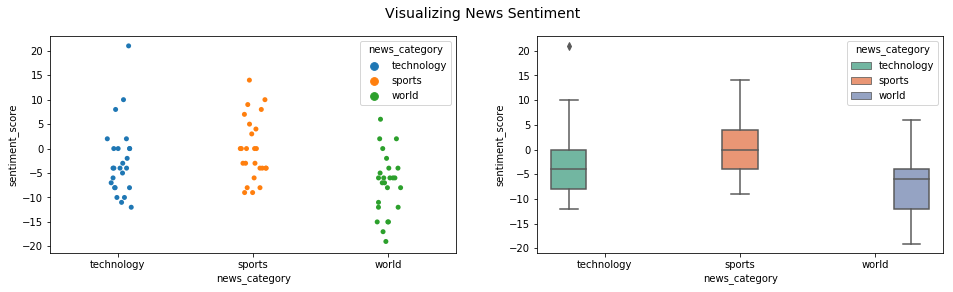

In [70]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sp = sns.stripplot(x='news_category', y="sentiment_score", 
                   hue='news_category', data=df, ax=ax1)
bp = sns.boxplot(x='news_category', y="sentiment_score", 
                 hue='news_category', data=df, palette="Set2", ax=ax2)
t = f.suptitle('Visualizing News Sentiment', fontsize=14)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


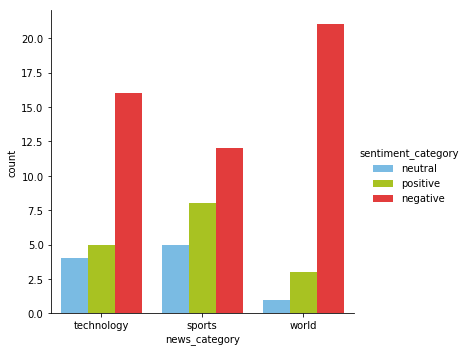

In [71]:
fc = sns.factorplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

In [72]:
pos_idx = df[(df.news_category=='world') & (df.sentiment_score == 6)].index[0]
neg_idx = df[(df.news_category=='world') & (df.sentiment_score == -19)].index[0]

print('Most Negative World News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive World News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative World News Article: Ethiopian Airlines Group CEO Tewolde GebreMariam visited the site of the crash in which all 157 people on board a Kenya-bound flight died on Sunday. "He deeply regrets the fatal accident...and regrets to confirm there are no survivors," a statement said. "He expresses his profound sympathy and condolences to the families and loved ones of passengers and crew," it added.

Most Positive World News Article: Greece's Antonis Mavropoulos, who was saved from the Ethiopian Airlines crash after he arrived two minutes late for the flight, has written a Facebook post titled 'My lucky day', following the accident. He revealed he was questioned by airport authorities as he was the only passenger booked onto the flight who wasn't on board. "I'm grateful to live," Antonis added.


In [81]:
pos_idx = df[(df.news_category=='technology') & (df.sentiment_score == 21)].index[0]
neg_idx = df[(df.news_category=='technology') & (df.sentiment_score == -12)].index[0]

print('Most Negative Tech News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive Tech News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative Tech News Article: The district authorities of Bhavnagar and Gir Somnath in Gujarat have issued a notification imposing a ban on online multiplayer game PUBG, after it was recently banned in Rajkot. The notification states that games like PUBG incite violence in players. It reportedly stated that people caught playing the game during the ban can be prosecuted under Section 188 of IPC. 

Most Positive Tech News Article: US technology giant Google's India-born CEO Sundar Pichai reached Mumbai to celebrate International Women's Day 2019 on Friday. "Happy to celebrate #IWD2019 with the India chapter of Women@Google at their 'I Am Remarkable' event," Pichai tweeted. "Thank you for inspiring me with your stories about the experiences, challenges and triumphs of being women in tech," the 46-year-old added.


# Sentiment Analysis with TextBlob

In [82]:
!pip install textblob

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [83]:
from textblob import TextBlob

# compute sentiment scores (polarity) and labels
sentiment_scores_tb = [round(TextBlob(article).sentiment.polarity, 3) for article in news_df['clean_text']]
sentiment_category_tb = ['positive' if score > 0 
                             else 'negative' if score < 0 
                                 else 'neutral' 
                                     for score in sentiment_scores_tb]


# sentiment statistics per news category
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores_tb, sentiment_category_tb]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()


sentiment_score                                                 \
                        count     mean       std    min    25%    50%    75%   
news_category                                                                  
sports                   25.0  0.05300  0.156021 -0.250 -0.025  0.046  0.156   
technology               25.0 -0.02408  0.204957 -0.439 -0.114  0.000  0.067   
world                    25.0  0.02980  0.096663 -0.155  0.000  0.017  0.083   

                      
                 max  
news_category         
sports         0.290  
technology     0.500  
world          0.281

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


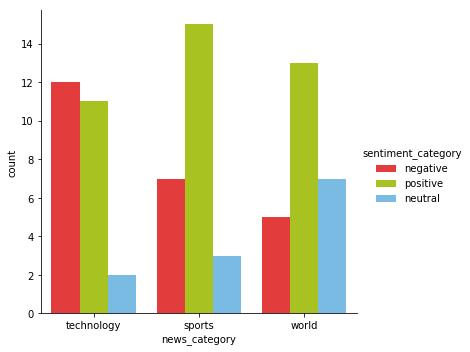

In [84]:
fc = sns.factorplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

In [85]:
pos_idx = df[(df.news_category=='world') & (df.sentiment_score == 0.281)].index[0]
neg_idx = df[(df.news_category=='world') & (df.sentiment_score == -0.155)].index[0]

print('Most Negative World News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive World News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative World News Article: All 14 people were killed in a plane crash in the Colombian plains province of Meta on Saturday, the country’s civil aviation agency said. A mayor of a small town in the jungle province of Vaupes was among those killed in the crash. The aircraft's navigability permissions were up-to-date, as were the medical certifications of its crew, the agency added.


Most Positive World News Article: As many as 22 United Nations officials were on board the Ethiopian Airlines plane that crashed on Sunday killing all 157 people on board. Some of these officials were en route to a major environmental conference in Nairobi, Kenya. The casualty list also included a professor, the CEO of a restaurant company and a Kenyan soccer official.


In [86]:
pos_idx = df[(df.news_category=='sports') & (df.sentiment_score == 0.290)].index[0]
neg_idx = df[(df.news_category=='sports') & (df.sentiment_score == -0.025)].index[0]

print('Most Negative Sports News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive Sports News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative Sports News Article: Former world number one Serena Williams retired from her third-round match at Indian Wells while trailing 6-3, 1-0 against Garbine Muguruza. Serena, who has twice won the title at Indian Wells in the past, later said, "Before the match, I did not feel great and then it just got worse with every second, extreme dizziness and extreme fatigue."

Most Positive Sports News Article: Arsenal inflicted Manchester United with their first Premier League defeat under coach Ole Gunnar Solskjaer after registering a 2-0 win at the Emirates Stadium on Sunday. With the win, Arsenal have leapfrogged over Manchester United and are now one point behind third-placed Tottenham. United will face Wolves in the FA Cup, while Arsenal will face Rennes in the Europa League.


In [87]:
pos_idx = df[(df.news_category=='technology') & (df.sentiment_score == 0.5)].index[0]
neg_idx = df[(df.news_category=='technology') & (df.sentiment_score == -0.114)].index[0]

print('Most Negative Tech News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive Tech News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative Tech News Article: The FBI has told American software giant Citrix it believed "international cyber criminals" had gained access to its data. Citrix said hackers might have accessed and downloaded business documents. Security firm Resecurity claimed hackers stole at least 6TB of documents focused on project data of the FBI and NASA, among others in attacks in December 2018 and March 2019.

Most Positive Tech News Article: Sella Nevo, the engineer leading Google's Flood Forecasting Initiative in Patna, said Google chose Patna for the project as it has an incredibly interesting and challenging location. "There are a lot of things like embankments and other man-made structures that we need to be able to deal with," said Nevo. Google is using machine learning to improve flood forecasting systems.


# Evaluation

In [105]:
from sklearn.metrics import confusion_matrix

In [113]:
confusion_matrix(sentiment_category, sentiment_category_tb)

array([[20, 10, 19],
       [ 3,  1,  6],
       [ 1,  1, 14]], dtype=int64)